In [1]:
import seaborn as sns

# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia
import pytorch_lightning as pl
from pytorch_lightning.loggers.neptune import NeptuneLogger
import neptune
import neptunecontrib.monitoring.optuna as optuna_utils
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import optuna
from datetime import datetime
import socket, plotly
from pathlib import Path
import torch.nn, gc, psycopg2
import sys, traceback
from glia.reconstructions.lib import resize_3d, gray_3d, ImageData, RetinaData, \
     ConcatDataset, ImageRetina
from sqlalchemy import create_engine
import pandas as pd

# sys.argv = [None, "/mnt/fs1/tbenst/200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5",
#             "/mnt/fs1/tbenst/models/3brain/", "9"]

sys.argv = [None, "/data/uw/200623_faces/merged/R1_E3_AMES_200min_200f_14l_rgb_drop_noise.h5",
           "/data/uw/models/", "0"]

filepath = sys.argv[1]
# model_base_dir = "/storage/models/retina-reconstruction"
model_base_dir = sys.argv[2]
gpus = [ int(sys.argv[3]) ]

pw = os.environ["POSTGRES_OPTUNA_PASSWORD"]
server = os.environ["POSTGRES_SERVER"]
port = os.environ["POSTGRES_PORT"]
user = os.environ["POSTGRES_OPTUNA_USER"]
# validate password

engine = create_engine(f'postgresql://{user}:{pw}@{server}:{port}/optuna')
with engine.connect() as connection:
    result = connection.execute("select * from trials limit 1;")


# open file
hdf5 = tables.open_file(filepath,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pkg_resources/__init__.py:1149: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).get_resource_stream(
/home/tyler/code/dura/glia/glia/files.py:69: DeprecationWarning: invalid escape sequence \d
  m = re.match("adc(\d+)",row[0])
/home/tyler/code/dura/glia/glia/files.py:326: DeprecationWarning: invalid escape sequence \d
  return int(re.search("Sample rate = (\d+)", header).group(1))
/home/tyler/code/dura/glia/glia/files.py:344: DeprecationWarning: invalid escape sequence \.
  result_regex = re.compile('.*\.result.hdf5$')


In [3]:
@dataclass
class RetinaOnOffData(Dataset):
    # we use HDF5 for compression of sparse data
    # otherwise, RAM would blow up. But after binning, not so large
    retina_data:tables.carray.CArray
    nbins:int = 10
        # collapse units into channel
    no_units:bool = False
    on_or_off:str = 'on'
    def __post_init__(self):
        if self.on_or_off=='on':
            self.start = 0
            self.end = self.retina_data.shape[1]/2
        else:
            self.start = self.retina_data.shape[1]/2
            self.end = self.retina_data.shape[1]
        slices = np.linspace(self.start, self.end, self.nbins+1, True).astype(np.int)
        bin_func = partial(np.add.reduceat, indices=slices[:-1], axis=0, dtype=np.float32)
        # THWC
        binned = np.array(glia.pmap(bin_func, self.retina_data, progress=True))
        # TCHW
        binned = torch.from_numpy(np.moveaxis(binned,-1,2))
        if self.no_units:
            binned = binned.sum(2, keepdims=True)
        self.data = binned
        
    def __len__(self):
        return self.retina_data.shape[0]
    def __getitem__(self,i):
        return self.data[i]

In [4]:
image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])

In [9]:
# retina_dset = RetinaOnOffData(h5["data"], no_units=False, on_or_off=False)
retina_dset = RetinaData(h5["data"], nbins=10)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([10, 6, 64, 64]))

In [6]:
from glia.reconstructions.models.john_conv import ConvNet

In [7]:
import hdbscan

## HDBSCAN experiments...
Not working well atm. ignore

In [7]:
mean_response = retina_dset.data.mean(0).numpy().reshape(10,-1).swapaxes(0,1)

In [18]:
h5["data"].shape

(2800, 1000, 64, 64, 6)

In [19]:
numSamples = len(h5["data"])
mean_response_1ms = np.zeros(h5["data"].shape[1:])
for c in tqdm(range(0,numSamples,200)):
    mean_response_1ms += h5["data"][c:c+200].sum(0)
mean_response_1ms /= numSamples

In [62]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)

In [63]:
clusterer.fit(mean_response)
clusterer.labels_.max()

4

In [56]:
import scipy.signal as signal

In [40]:
rgcs = mean_response_1ms.reshape(1000,-1).swapaxes(0,1)
spike_counts = np.sum(np.array(rgcs),1)

# estimate firing rate using gaussian smoothing
sigma = 6
bandwidth = 0.05 # sec
bin_width = 0.001
transformed_sigma = bandwidth/bin_width
window = signal.gaussian(2*sigma*transformed_sigma, std=transformed_sigma)

# instantaneous firing rate (acausal)
ifr = np.array([signal.convolve(unit, window,mode="same")*1/bandwidth for unit in rgcs])

5


(       cluster    0    1    2    3    4    5    6    7    8  ...  990  991  \
 0         -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 1         -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 2         -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 3         -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 4         -1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 ...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 24571      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 24572      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 24573      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 24574      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 24575      4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 
        992  993  994  995  996  997  998  999  
 

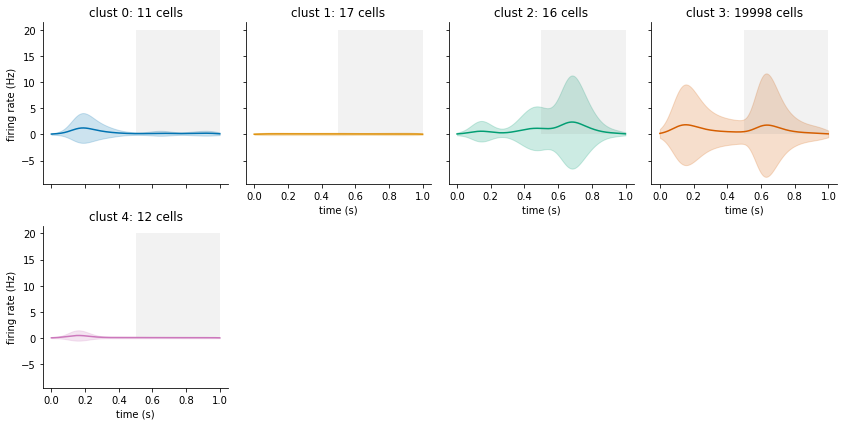

In [64]:
def plot_cluster_traces(labels, ifr, csv_name=None):
    """
        data: matrix used for clustering
        r
    """
    cells = []
    ncells = []
    nclust = max(labels)+1
    print(nclust)
    # for c in range(-1,nclust):
    # ignore unclustered
    for c in range(-1,nclust):
        ncell = np.sum(labels==c)
        ncells.append(ncell)
        # cells.append(np.concatenate([np.full([ncells,1],f"clust {c}: {ncells}"),data[labels==c]],1))
        # print(len(np.array(rgcs.iloc[rows,0][labels==c])),np.sum(labels==c))
        cells.append(np.concatenate([
            np.full([ncell,1],c), # cluster
            ifr[labels==c] # firing rate
            ],1)
            )

    cells = pd.DataFrame(data=np.concatenate(cells),columns = \
        ["cluster"]+list(np.arange(ifr.shape[1])))
    # collapse columns (time) to long format, one row per timepoint
    melt_cells = cells.melt('cluster', var_name='time',  value_name='spikes')

    # Why? pandas craziness
    melt_cells.cluster = melt_cells.cluster.astype(float)
    melt_cells.spikes = melt_cells.spikes.astype(float)
    melt_cells.time = melt_cells.time.astype(float)/1000 # convert to seconds

    if csv_name:
        cells.iloc[:,:3].to_csv(f"{csv_name}.csv")

    # %#%
    # plot firing rate
    # drop unclustered
    melt_cells = melt_cells[melt_cells.cluster!=-1]
    melt_cells.cluster.unique()
    # must be categorical for seaborn
    palette = sns.color_palette("colorblind", nclust)
    len(palette)

    # melt_cells_new = melt_cells
    ymin = 0
    # letters
    ymax = 250
    # gratings
    ymax = 20
    nrow = ((nclust-1) // 4) + 1
    g = sns.FacetGrid(melt_cells, col="cluster", hue="cluster", col_wrap=4, height=nrow, palette=palette, size=3)
    g.map(sns.lineplot, "time", "spikes", legend=False, ci="sd");

    offset = 0.5
    end_time = 1
    # offset = 4
    # end_time = 9 + 1
    for c,ax in zip(np.arange(0,nclust),g.axes):
        ax.set_title(f"clust {c}: {np.sum(labels==c)} cells")
        ax.fill([offset,end_time,end_time,offset],
                        [ymin,ymin,ymax,ymax],
                        facecolor="gray",
                        edgecolor="none", alpha=0.1)

    [ax.set_ylabel("firing rate (Hz)") for ax in g.fig.axes]
    [ax.set_xlabel("time (s)") for ax in g.fig.axes]
    return cells, g.fig

plot_cluster_traces(clusterer.labels_, ifr)

<AxesSubplot:ylabel='$\\lambda$ value'>

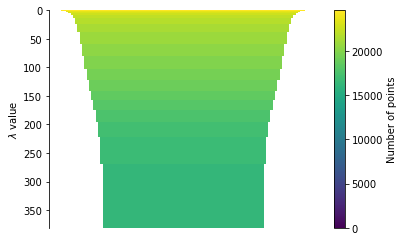

In [53]:
clusterer.condensed_tree_.plot()

In [28]:
np.where(clusterer.labels_==0)[0]

array([ 862, 1258, 1380, 1444, 1455, 1456, 1503, 1875, 1885, 4958, 5401,
       5787, 5917, 5931, 9947])

(array([34., 17., 20., 36., 10., 34., 26., 35., 23., 27.]),
 array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. , 16.8, 19.6, 22.4, 25.2, 28. ]),
 <BarContainer object of 10 artists>)

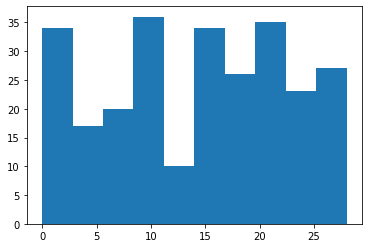

In [27]:
plt.hist(clusterer.labels_[np.logical_and(clusterer.labels_!=-1, clusterer.labels_!=max(clusterer.labels_))])

### back to model training

In [ ]:
nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
dm = ImageRetina(image_dset, retina_dset,batch_size=50,
                 tvt_idxs=(train_idx, val_idx, test_idx))

now_str = datetime.now().isoformat()
save_dir = os.path.join(model_base_dir,
    now_str)

MODEL_NAME="john_convnet"
model = ConvNet(filters=244, nLayers=144,
               example_input_array=retina_dset[0][None],
               nCelltypes = 6, einsum=True)

neptune_logger = NeptuneLogger(
    api_key=os.environ["NEPTUNE_API_TOKEN"],
    project_name="tbenst/retina",
    params=model.hparams,
    experiment_name=MODEL_NAME,  # Optional,
    tags=["john_convnet", "ON_OFF_response", "auto-lr-finder"],
#     offline_mode=True
)

monitor="val_mse_loss"
save_name = MODEL_NAME+"_{epoch}_{"+monitor+":.2f}"
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_dir,save_name),
    save_top_k=1,
    verbose=False,
    monitor=monitor,
    mode='min',
    prefix=''
)
    
trainer = pl.Trainer(gpus=[0], logger=neptune_logger, default_root_dir=save_dir, max_epochs=675, auto_lr_find=True)
trainer.fit(model, dm)

mse=tensor(9846.2725, device='cuda:0', grad_fn=<DivBackward0>)


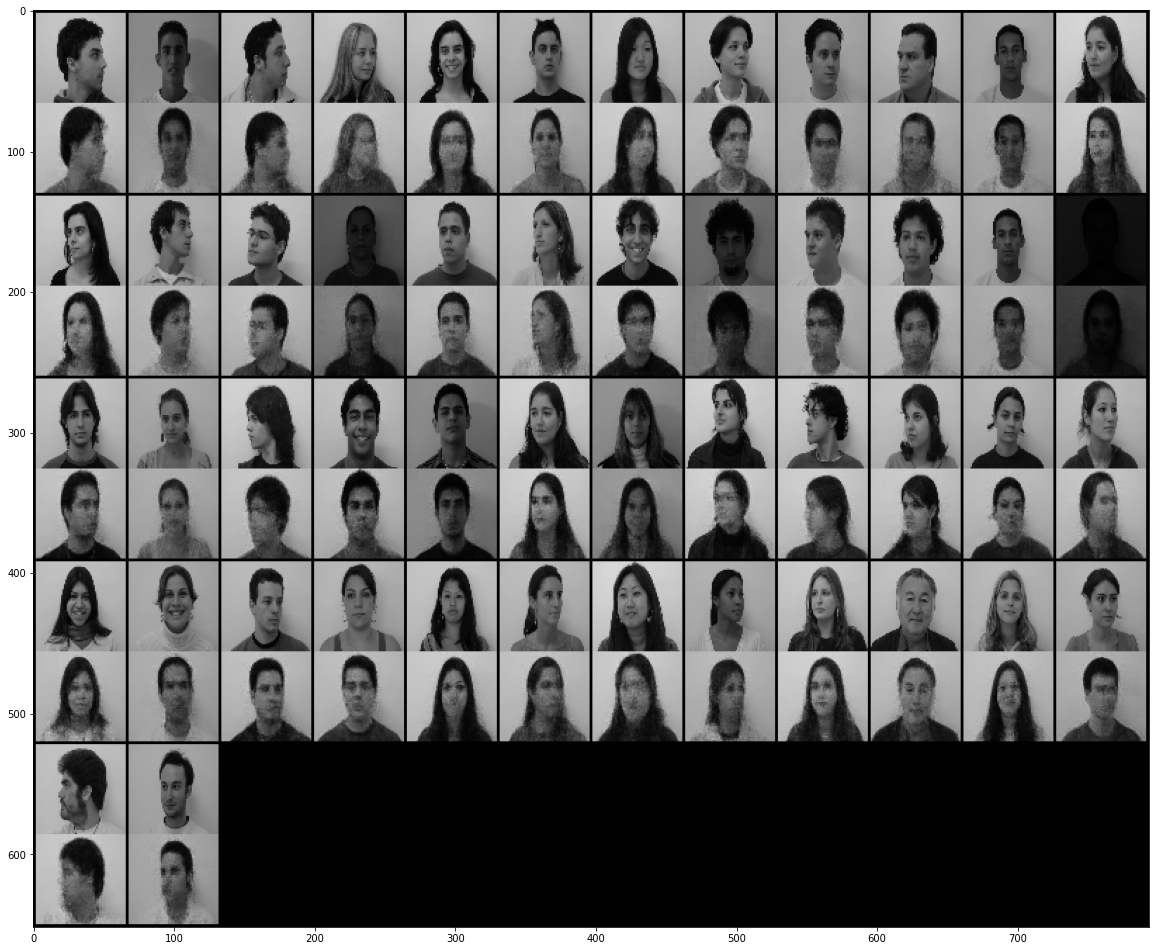

In [11]:
for batch in dm.val_dataloader():
    bz = batch[0].shape[0]
    images, retina = batch
    images_pred = model(retina.cuda()/30)
    mse = F.mse_loss(images.cuda(), images_pred, reduction="sum")/bz
    print(f"{mse=}")
    break

comparison = torch.cat([images.view(-1,1,64, 64),
               images_pred.view(-1,1,64, 64).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)
plt.savefig("")

In [21]:
save_name

'john_convnet_{epoch}_{val_mse_loss:.2f}'

In [20]:
!ls /data/uw/models/2020-10-29T19:10:21.287362/john_convnet/RET-1552/checkpoints

'epoch=502.ckpt'
